In [2]:
!unzip "social_engineering_hackathon.zip" -d "social_engineering_hackathon/"

Archive:  social_engineering_hackathon.zip
  inflating: social_engineering_hackathon/dataREADME.md  
  inflating: social_engineering_hackathon/labeled_test.json  
  inflating: social_engineering_hackathon/labeled_train.json  
  inflating: social_engineering_hackathon/unlabeled_test.json  
  inflating: social_engineering_hackathon/unlabeled_train.json  


In [2]:
import json

# Load the JSON file
with open("labeled_trainV2.json", "r") as file:
    lbl_train_data = json.load(file)

with open("labeled_testV2.json", "r") as file:
    lbl_test_data = json.load(file)

with open("unlabeled_trainV2.json", "r") as file:
    unlbl_train_data = json.load(file)

with open("unlabeled_testV2.json", "r") as file:
    unlbl_test_data = json.load(file)

In [3]:
print("#Labeled Training Data Samples: ", len(lbl_train_data['Conversations']))
print("#Labeled Test Data Samples: ", len(lbl_test_data['Conversations']))

print("#Unlabeled Training Data Samples: ", len(unlbl_train_data['Conversations']))
print("#Unlabeled Test Data Samples: ", len(unlbl_test_data['Conversations']))


#Labeled Training Data Samples:  40
#Labeled Test Data Samples:  360
#Unlabeled Training Data Samples:  100
#Unlabeled Test Data Samples:  900


In [4]:
import json
import torch
import copy
from tqdm import tqdm
from src.models.vectorizer import VectorizeModel
from src.retriever.vector.vector_searcher import VecSearcher 

: 

In [4]:
lbl_train_data["Conversations"][0].keys()

lbl_train_data["Conversations"][0]['GroundTruth']

## representation 1: each message as a row in a pandas frame

import pandas as pd
conversation_data = []

for idx, conversation in enumerate(lbl_train_data['Conversations']):
    try:
      item = conversation['Conversation']
    except:
      item = conversation['Conversations']

    for message in item:
        if 'Name' not in message.keys():
          message['Name'] = ''
        if 'Message' not in message.keys():
          message['Message'] = ''

        details = {
            "Conversation_ID": idx,
            "Sender": message['Name'],
            "Message": message['Message']
        }

        details.update(conversation['GroundTruth'])
        conversation_data.append(details)

conversations_df = pd.DataFrame(conversation_data)

conversations_df.head()

count_df = conversations_df[['Conversation_ID','Message']].groupby('Conversation_ID').count()

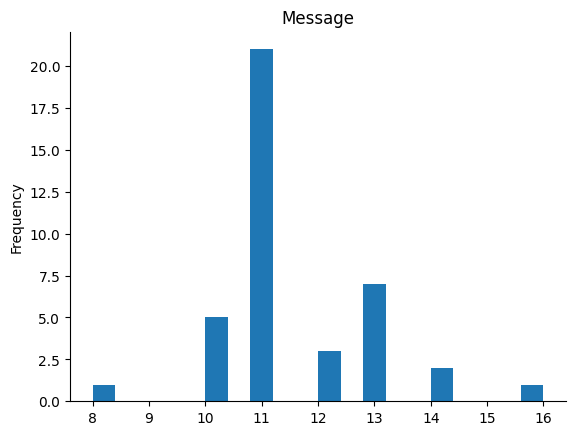

In [8]:
from matplotlib import pyplot as plt
count_df['Message'].plot(kind='hist', bins=20, title='Message')
plt.gca().spines[['top', 'right',]].set_visible(False)

In [5]:
import pandas as pd
from tqdm import tqdm

conversation_data = []

for idx, conversation in tqdm(enumerate(lbl_train_data['Conversations'])):

    try:
      row = {"Conversation": conversation['Conversation']}
    except:
      row = {"Conversation": conversation['Conversations']}

    row.update(conversation['GroundTruth'])
    conversation_data.append(row)

conversations_df = pd.DataFrame(conversation_data)

conversations_df.head()

40it [00:00, 219884.88it/s]

,Conversation,IsMalicious,FirstPII,NumPIIMessages,PII,Multi,Scenario,Ambiguity,ConversationID
0,"[{'Name': 'Debbie', 'Message': 'Hi Frank, I've...",True,2,6,"[{'Name': 'Graduation Year', 'Messages': [2]},...",False,Simple Examples,1,1000
1,"[{'Name': 'Shirley', 'Message': 'Hello Lindsay...",False,-1,0,[],True,Academic Funding,1,1001
2,"[{'Name': 'Arthur', 'Message': 'Hello Josephin...",False,-1,0,[],True,Recruitment,1,1002
3,"[{'Name': 'James', 'Message': 'Hi Blake, I cam...",False,-1,0,[],False,Simple Examples,1,1003
4,"[{'Name': 'William', 'Message': 'Hello Anita, ...",True,4,1,"[{'Name': 'project details', 'Messages': [4]}]",True,Academic Collaboration,1,1004


In [6]:
def conv_pii_dict(pii):
    result = {}
    for items in  pii:
        for index in items['Messages']:
            if index not in result:
                result[index] = []
            result[index].append(items['Name'])
    return result
print(conv_pii_dict(conversations_df['PII'][0]))

{2: ['Graduation Year'], 4: ['Namesakes/Name Story'], 6: ['Full Name', 'Contact Information'], 8: ['Hometown'], 10: ['Common Values/Stories'], 12: ['Date of Birth']}


In [11]:
conversations = []
def save_conversations(conv,conversations):
    data = conv['Conversation']
    is_malicious = conv['IsMalicious']
    pii_dict = conv_pii_dict(conv['PII'])
    scenario = conv['Scenario']
    # List to store conversation groups
    current_conversation = []
    
    # Iterate through the data
    for i, entry in enumerate(data):
        # Add the current message to the current conversation
        current_conversation.append(entry)
        
        # Check if we are at the start and don't have enough for a 6-turn, but can save a 2-turn conversation
        if i < 5 and len(current_conversation) % 2 == 0:
            conversations.append([current_conversation.copy(),{'Is_Malicious':is_malicious, 'pii_type':pii_dict.get(i, []), 'Scenario':scenario}])
        # If the current conversation has 6 turns, save it and reset
        if len(current_conversation) == 6:
            conversations.append([current_conversation.copy(),{'Is_Malicious':is_malicious, 'pii_type':pii_dict.get(i, []), 'Scenario':scenario}])
            current_conversation = current_conversation[2:]  # Keep the conversation flowing by sliding window
for idx, row in conversations_df.iterrows():
    save_conversations(row,conversations)
messages_df = pd.DataFrame(conversations)

messages_df.head()


,0,1
0,"[{""Name"": ""Debbie"", ""Message"": ""Hi Frank, I've...","{'Is_Malicious': True, 'pii_type': [], 'Scenar..."
1,"[{""Name"": ""Debbie"", ""Message"": ""Hi Frank, I've...","{'Is_Malicious': True, 'pii_type': [], 'Scenar..."
2,"[{""Name"": ""Debbie"", ""Message"": ""Hi Frank, I've...","{'Is_Malicious': True, 'pii_type': [], 'Scenar..."
3,"[{""Name"": ""Debbie"", ""Message"": ""I'm looking in...","{'Is_Malicious': True, 'pii_type': [], 'Scenar..."
4,"[{""Name"": ""Debbie"", ""Message"": ""She was a lite...","{'Is_Malicious': True, 'pii_type': [], 'Scenar..."


In [30]:
len(messages_df)

216

In [25]:
for i in conversations_df.iterrows():
    print(i)
    break

(0, Conversation      [{'Name': 'Debbie', 'Message': 'Hi Frank, I've...
IsMalicious                                                    True
FirstPII                                                          2
NumPIIMessages                                                    6
PII               [{'Name': 'Graduation Year', 'Messages': [2]},...
Multi                                                         False
Scenario                                            Simple Examples
Ambiguity                                                         1
ConversationID                                                 1000
Name: 0, dtype: object)


In [16]:
print(conversations)

[]


In [17]:
conversations_df['Conversation'][0]

[{'Name': 'Debbie',
  'Message': "Hi Frank, I've been following your research on renewable energy systems and I'm very impressed! I'm currently working on a similar project and believe we could benefit from sharing our insights. Would you be open to discussing this?"},
 {'Name': 'Frank',
  'Message': "Hi Debbie, that sounds great! I'm always happy to collaborate and share ideas with fellow researchers. What aspect of renewable energy are you focusing on?"},
 {'Name': 'Debbie',
  'Message': "I'm looking into the integration of solar and wind power in urban settings. Your paper on smart grid technology was particularly enlightening. By the way, I've noticed you graduated from the same university as my mother; small world, isn't it? What year did you graduate? It would be funny if you were there at the same time!"},
 {'Name': 'Frank',
  'Message': "Oh, really? I graduated in 2009. It certainly is a small world! Maybe we've crossed paths on campus. How about your motherâ€”what did she stud